# Earth quake
> graph laplacian

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA]

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [331]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1970"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/1970,-29.4000,-177.1690,5.6,1970
1,01/04/1970,24.1850,102.5430,7.1,1970
2,01/05/1970,23.9840,102.7320,5.9,1970
3,01/06/1970,-9.5830,151.4930,6.3,1970
4,01/07/1970,15.7850,-59.8080,6.0,1970
...,...,...,...,...,...
21951,12/28/2016,38.3917,-118.8941,5.6,2016
21952,12/28/2016,38.3777,-118.8957,5.5,2016
21953,12/28/2016,36.9179,140.4262,5.9,2016
21954,12/29/2016,-9.0283,118.6639,6.3,2016


In [158]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2000"').reset_index().iloc[:,1:]
_df

,Date,Latitude,Longitude,Magnitude,Year
0,01/01/2000,-60.7220,153.6700,6.0,2000
1,01/02/2000,-17.9430,-178.4760,5.5,2000
2,01/02/2000,51.4470,-175.5580,5.8,2000
3,01/02/2000,-20.7710,-174.2360,5.8,2000
4,01/05/2000,-20.9640,-174.0970,5.6,2000
...,...,...,...,...,...
8739,12/28/2016,38.3917,-118.8941,5.6,2016
8740,12/28/2016,38.3777,-118.8957,5.5,2016
8741,12/28/2016,36.9179,140.4262,5.9,2016
8742,12/29/2016,-9.0283,118.6639,6.3,2016


##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [267]:
f_true = _df.loc[:,"Magnitude"]

In [268]:
f = f_true + np.random.normal(scale=0.2,size=len(f_true))

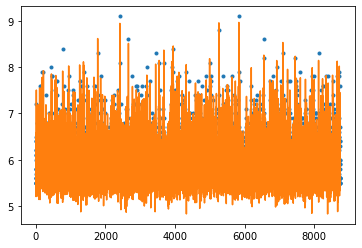

In [269]:
plt.plot(f_true,'.')
plt.plot(f,'-')

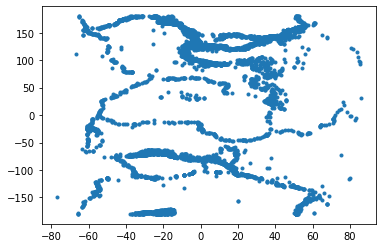

In [7]:
plt.plot( _df.Latitude,_df.Longitude,'.')

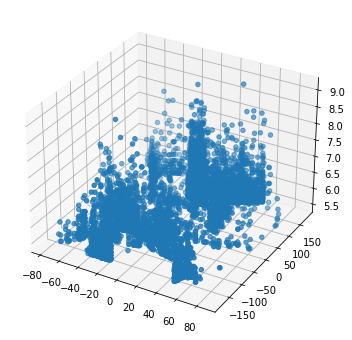

In [8]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude)
#ax.scatter(_df.Latitude, _df.Longitude, 0)

In [260]:
from mpl_toolkits.basemap import Basemap

In [261]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

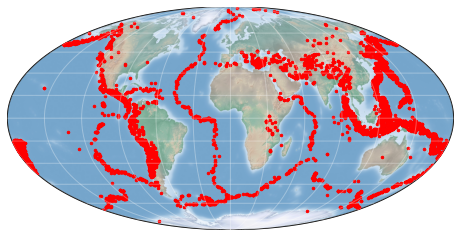

In [279]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=5)
draw_map(m)

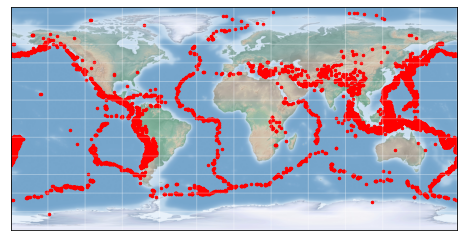

In [280]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=5)
draw_map(m)

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
    - 반대편으로 갈 수 있는 경우 반대편 각을 구하기 위하여 경도 차이의 절대값이 180도를 넘는 경우 360도를 빼주는 조건 추가

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [9]:
def dist(i,j):
    if abs( _df.Longitude[j] - _df.Longitude[i] ) >= 180: 
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i] -360)**2) )  
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1이 될터.)

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [10]:
def weight(i,j,theta=10,kappa=100):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [11]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [12]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.   , 0.994],
       [0.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.994, 0.   , 1.   ]])

그래프

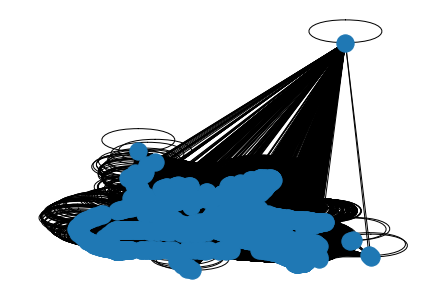

In [13]:
nx.draw(nx.Graph(W))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [14]:
D = np.diag(W.sum(axis=1))

In [15]:
D

array([[ 92.89142939,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 734.82175206,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 144.97673324, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 748.19048089,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        480.97728751,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 754.19684425]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [16]:
L = D - W

In [17]:
L

array([[ 9.18914294e+01, -2.19475357e-06,  0.00000000e+00, ...,
        -8.26583284e-22, -3.43816381e-09, -5.86138347e-22],
       [ 0.00000000e+00,  7.33821752e+02, -3.35684620e-11, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -3.35684620e-11,  1.43976733e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.26583284e-22, -6.26324521e-11, -2.16084313e-05, ...,
         7.47190481e+02, -2.44062848e-06, -9.94026527e-01],
       [-3.43816381e-09, -1.76640357e-09, -4.60171898e-18, ...,
        -2.44062848e-06,  4.79977288e+02, -1.57119318e-06],
       [-5.86138347e-22, -7.17173327e-11, -3.55131902e-05, ...,
        -9.94026527e-01, -1.57119318e-06,  7.53196844e+02]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [18]:
λ, Ψ = np.linalg.eig(L)

In [19]:
Λ = np.diag(λ)

---

푸리에

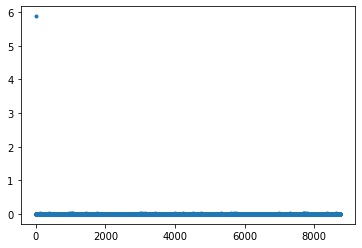

In [23]:
fbar = np.abs(np.fft.fft(f))/len(f)
plt.plot(fbar,'.')

In [24]:
fbar[0] 

5.878828448770139

In [25]:
len(f)/2

4372.0

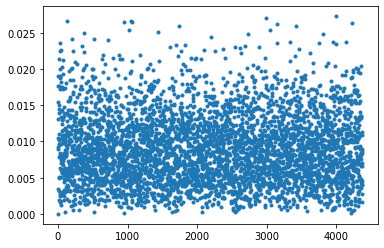

In [26]:
fbar2=np.zeros(4372)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:4372] = 2*fbar[1:4372]
plt.plot(fbar2,'.')

In [27]:
fbar2[:10]

array([0.        , 0.00920474, 0.01313762, 0.01763472, 0.00341781,
       0.00889426, 0.01548079, 0.01908777, 0.01041703, 0.00959476])

---

##### 8. $f \times \Psi \times \Psi^\top $

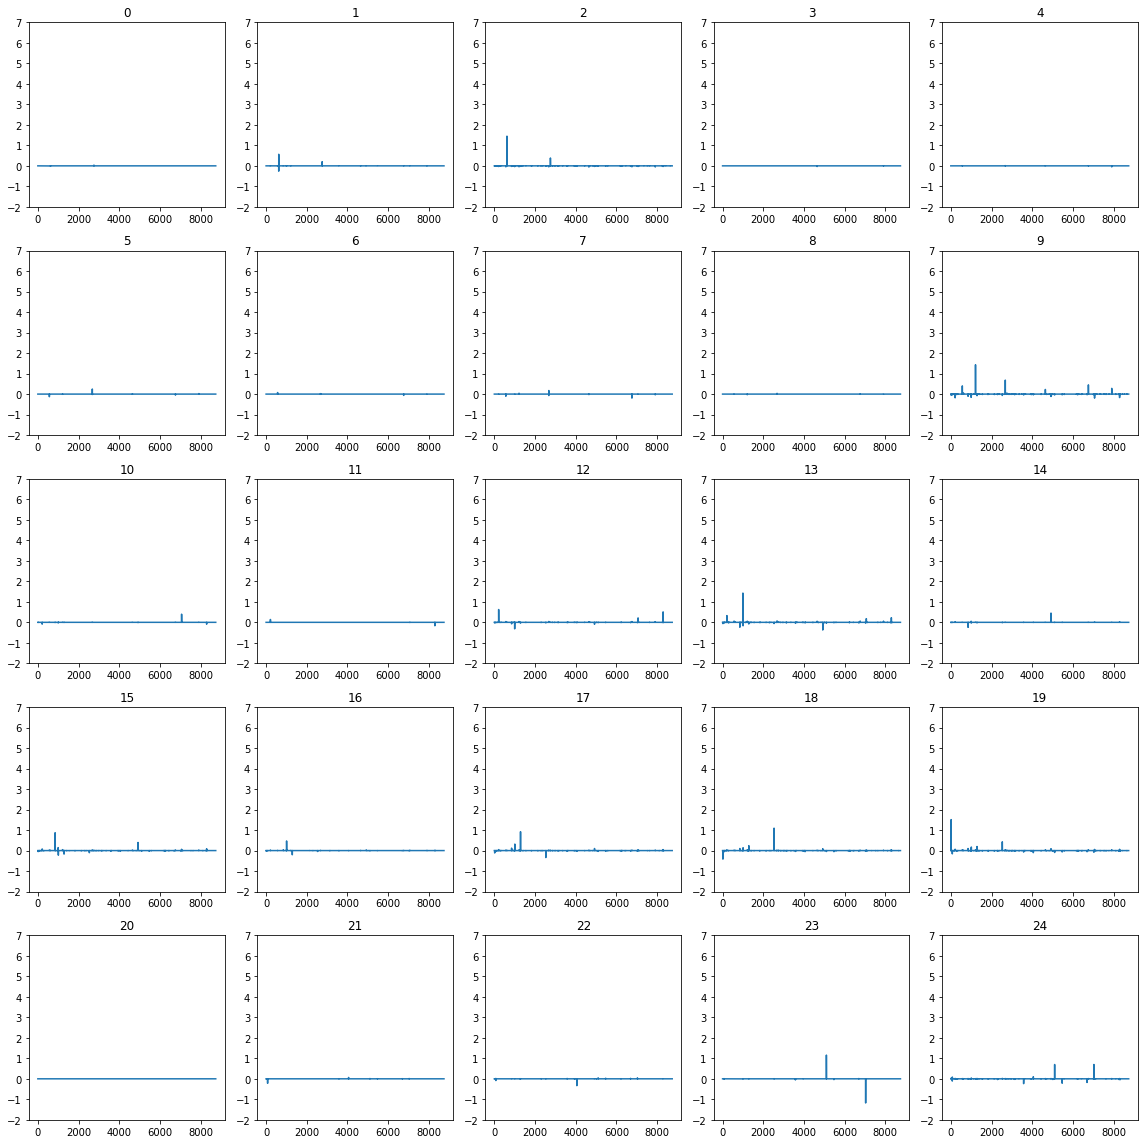

In [326]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

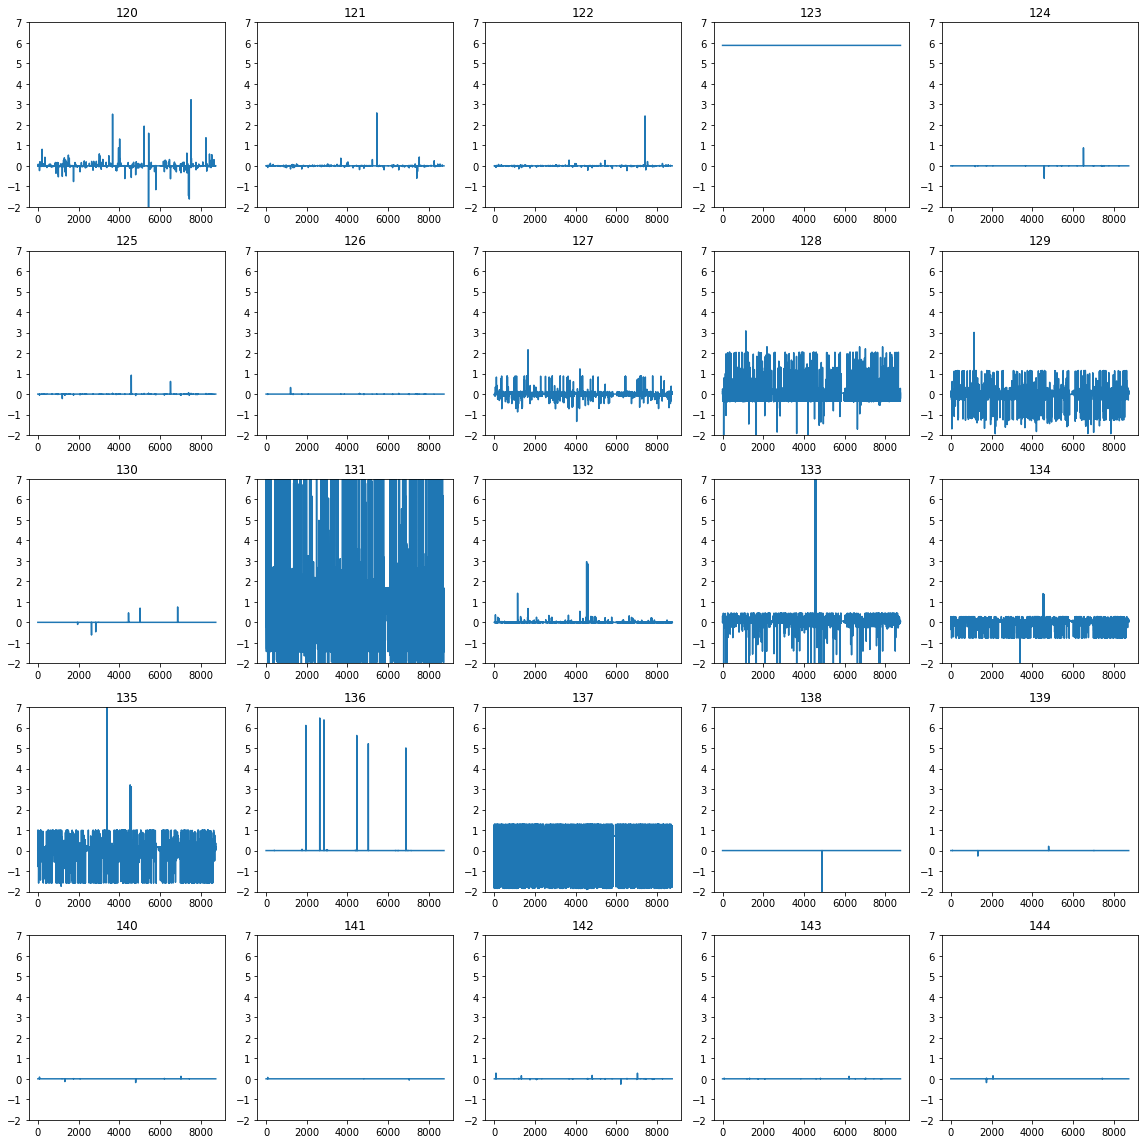

In [325]:
fig,ax =plt.subplots(5,5)
k=120
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

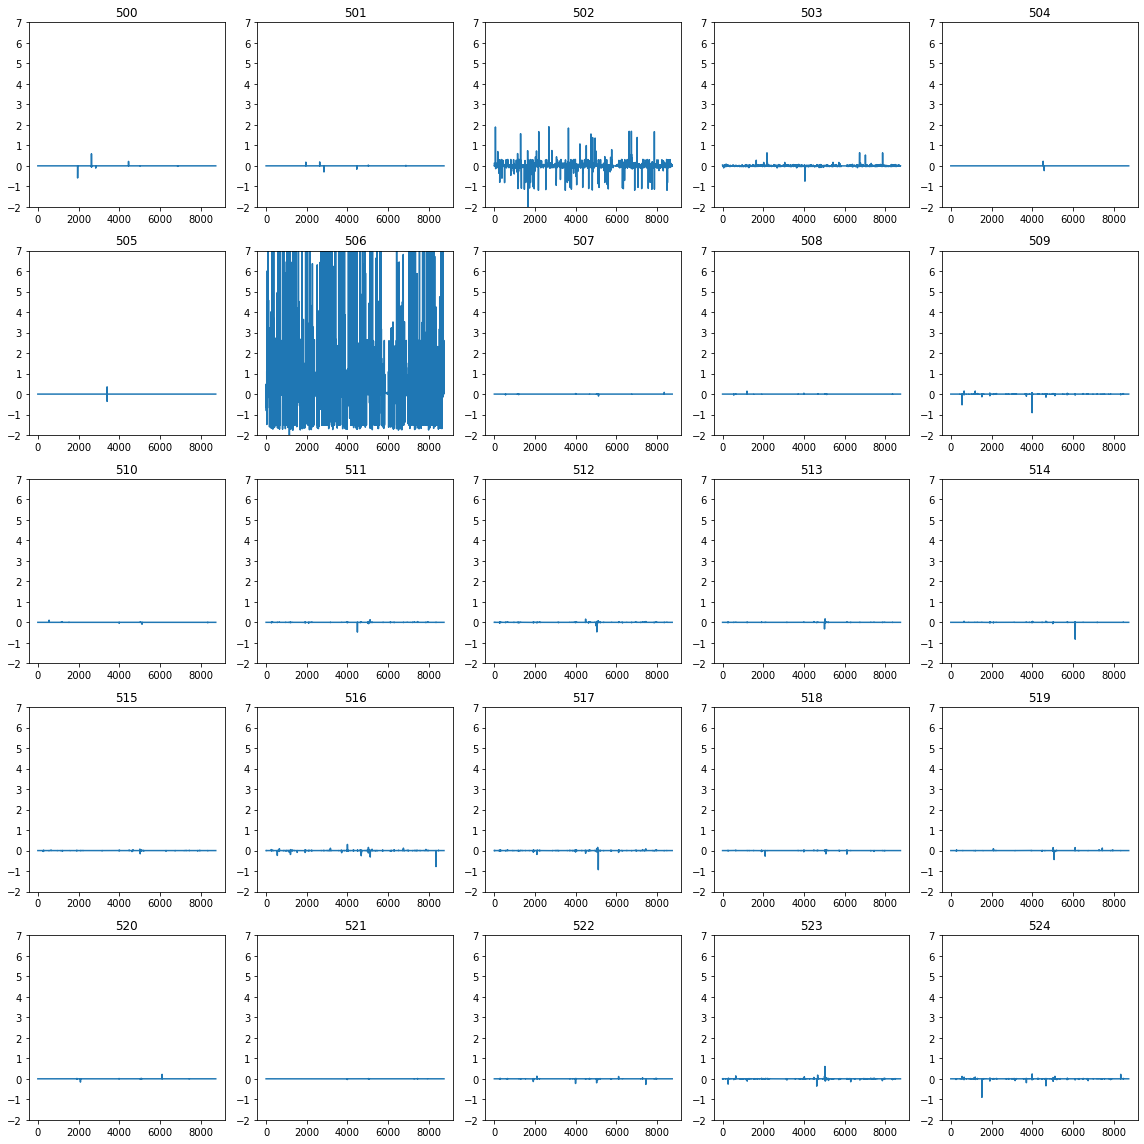

In [324]:
fig,ax =plt.subplots(5,5)
k=500
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

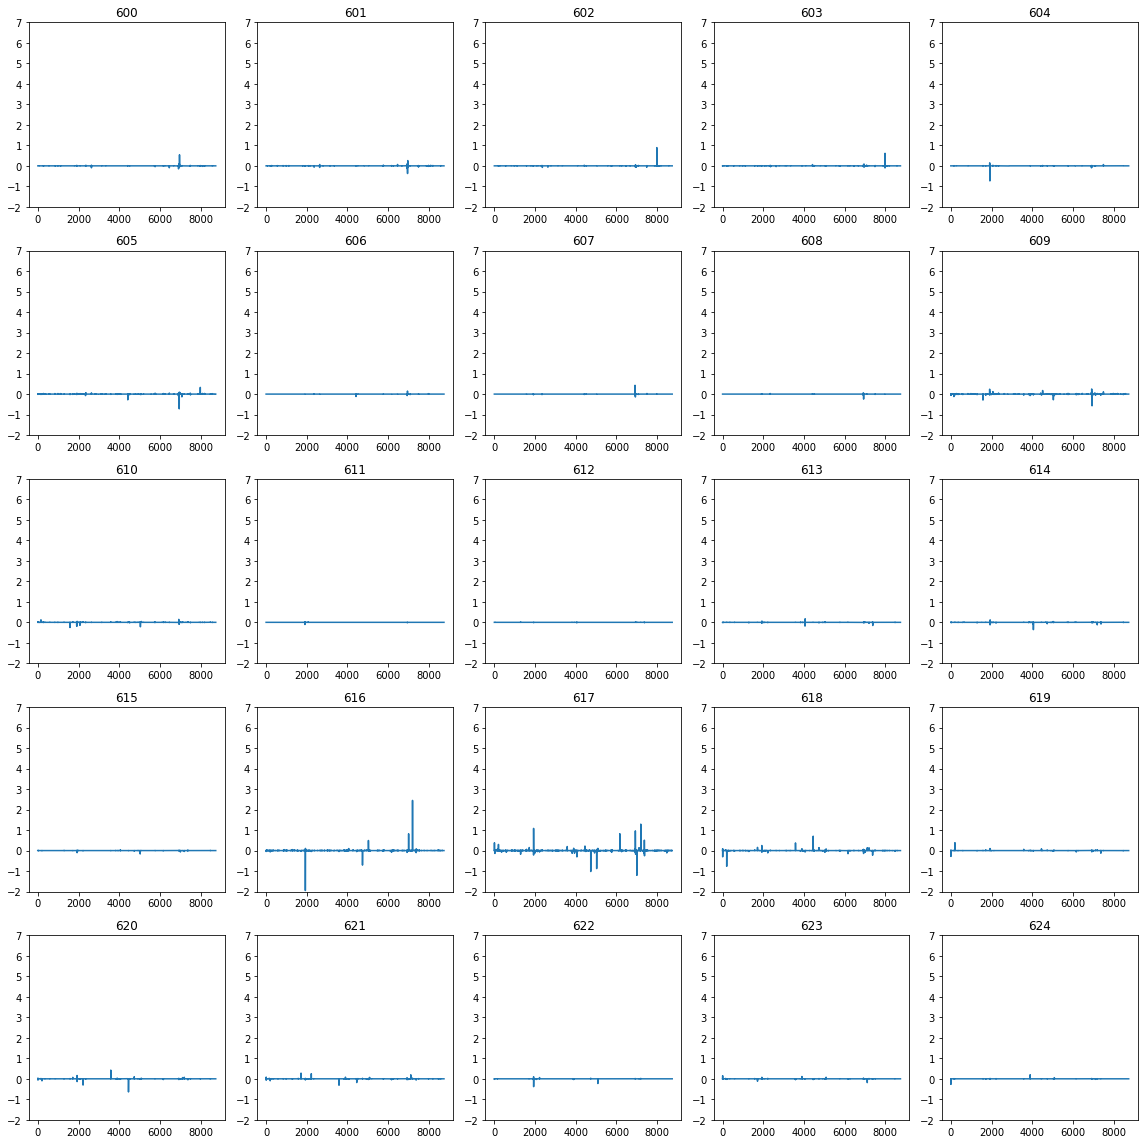

In [323]:
fig,ax =plt.subplots(5,5)
k=600
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,k], Ψ[:,k])))
        ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

평균을 나타내는 component

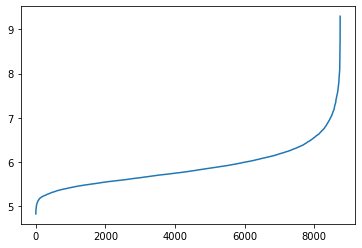

In [31]:
plt.plot(f[np.argsort(f)].reset_index().iloc[:,1])

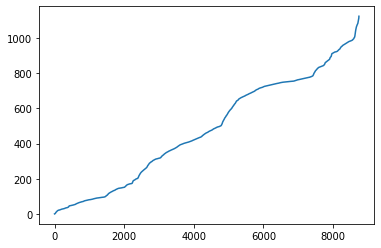

In [34]:
plt.plot(λ[np.argsort(λ)])

component 추정

In [310]:
np.argsort(λ)[0:20]

array([123, 138, 137, 136, 135, 134, 133, 132, 131, 671, 506, 130, 129,
       128, 672, 678, 679, 127, 505, 504])

In [311]:
np.argsort(λ)[-10:-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1])

In [312]:
np.mean(f)

5.878518092578041

In [313]:
np.mean(f @ np.outer(Ψ[:,123], Ψ[:,123]))

5.878518092577144

In [334]:
np.mean(f @ np.outer(Ψ[:,1], Ψ[:,1]))

1.117023720324583e-05

In [314]:
comphat1=f @ np.outer(Ψ[:,123], Ψ[:,123])

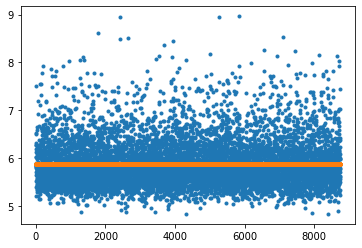

In [315]:
plt.plot(f,'.')
plt.plot(comphat1,'.')

component1 빼고 component2 추정

In [47]:
comphat2 =  f @ np.outer(Ψ[:,138], Ψ[:,138]) 

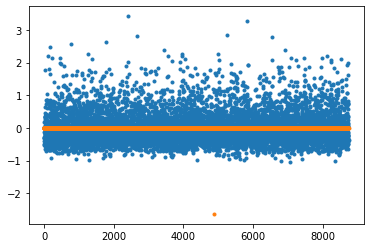

In [48]:
plt.plot(f-comphat1,'.')
plt.plot(comphat2,'.')

In [49]:
comphat3 =  f @ np.outer(Ψ[:,137], Ψ[:,137]) 

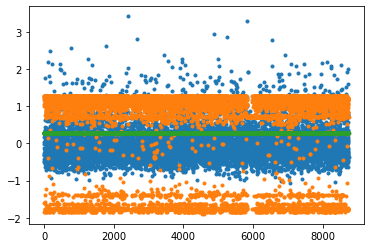

In [72]:
plt.plot(f-comphat1-comphat2,'.')
plt.plot(comphat3,'.')
plt.plot([np.mean(comphat3)]*len(f), '.')

In [52]:
comphat4 =  f @ np.outer(Ψ[:,136], Ψ[:,136]) 

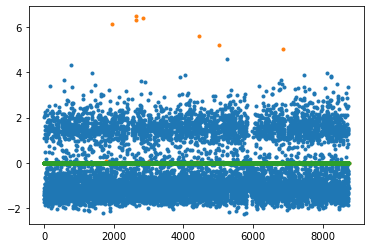

In [75]:
plt.plot(f-comphat1-comphat2-comphat3,'.')
plt.plot(comphat4, '.')
plt.plot([np.mean(comphat4)]*len(f), '.')

(4.0, 10.0)

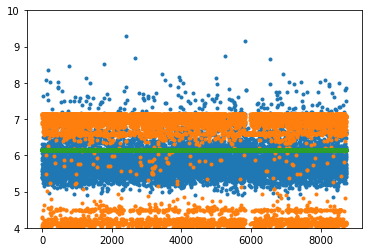

In [231]:
plt.plot(f,'.')
plt.plot(comphat1 + comphat2 + comphat3 + comphat4,'.')
plt.plot([np.mean(comphat1 + comphat2 + comphat3 + comphat4)]*len(f), '.')
plt.ylim(4,10)

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

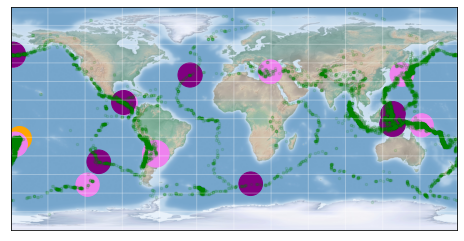

In [322]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)

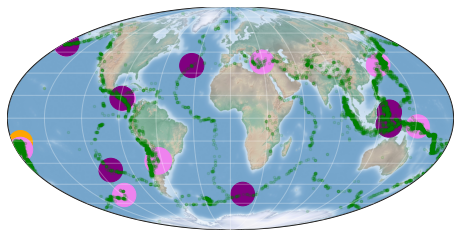

In [271]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)